In [64]:
import os
import cv2
import numpy as np
import joblib

def load_images_from_folder(folder):
    images = []
    labels = []
    for person_name in os.listdir(folder):
        person_folder = os.path.join(folder, person_name)
        if os.path.isdir(person_folder):
            for filename in os.listdir(person_folder):
                img_path = os.path.join(person_folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(cv2.resize(img, (100, 100)))  # Resize to 100x100 pixels
                    labels.append(person_name)
    return np.array(images), np.array(labels)

images, labels = load_images_from_folder('./data')

In [65]:
from skimage.feature import hog, local_binary_pattern


def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, block_norm='L2-Hys'):
    hog_features = []
    for img in images:
        features = hog(img, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, 
                       orientations=orientations, block_norm=block_norm, visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

def extract_lbp_features(images, P=8, R=1):
    lbp_features = []
    for img in images:
        # Convert image to grayscale if not already
        # if len(img.shape) == 3:
        #     img = rgb2gray(img)
        # 
        # Extract LBP features
        lbp = local_binary_pattern(img, P, R, method='uniform')
        hist, _ = np.histogram(lbp, bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype("float")
        hist /= hist.sum()  # Normalize the histogram
        lbp_features.append(hist)
    return np.array(lbp_features)

hog_features = extract_lbp_features(images)

In [66]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
labels_num = label_encoder.fit_transform(labels)

In [67]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

X, y = hog_features, labels_num

# Create a pipeline
n_samples, n_features = X.shape
n_components = min(n_samples, n_features) - 1
print(n_components)
pca = PCA(n_components=n_components, svd_solver='full')
svc = SVC(kernel='rbf', class_weight='balanced', probability=True)
model = make_pipeline(pca, svc)

# Train the model
model.fit(X, y)

# Save the trained model to a file
model_filename = 'face_verify_model.pkl'
joblib.dump(model, model_filename)
print(f'Model saved to {model_filename}')

9
Model saved to face_verify_model.pkl


In [68]:
from sklearn.metrics import accuracy_score, classification_report
predictions = model.predict(X)

accuracy = accuracy_score(y, predictions)
print(f'Accuracy: {accuracy:.2f}')
report = classification_report(y, predictions, output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1_score:.2f}')

Accuracy: 0.41
Precision: 0.31
Recall: 0.41
F1-Score: 0.33


/home/hknight/.conda/envs/cpv_project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/hknight/.conda/envs/cpv_project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/hknight/.conda/envs/cpv_project/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



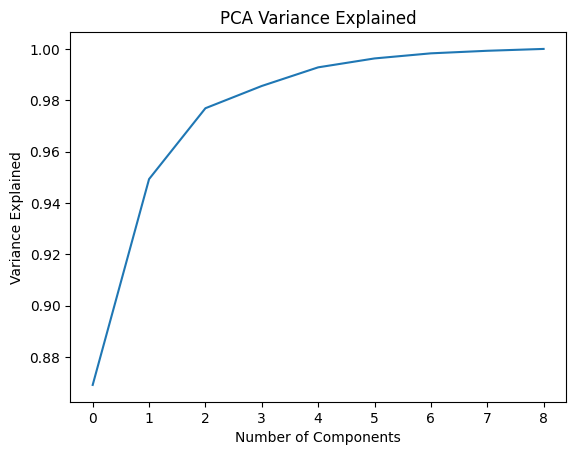

In [69]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('PCA Variance Explained')
plt.show()

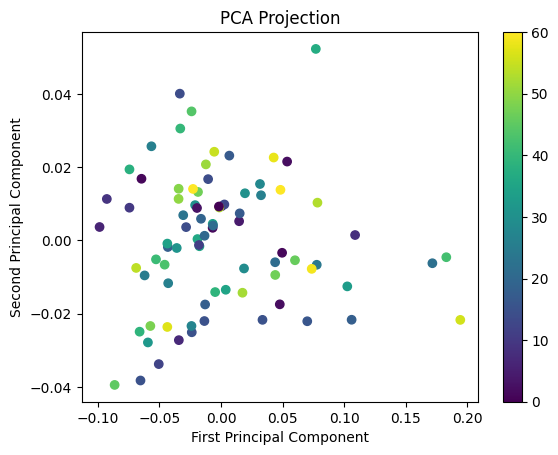

In [70]:
X_pca = pca.transform(X)
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_num, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Projection')
plt.colorbar()
plt.show()

In [71]:
import plotly.graph_objs as go
# Create a mesh grid for plotting decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict on the mesh grid
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create Plotly figure
fig = go.Figure()

# Add contour plot for decision boundary
fig.add_trace(go.Contour(
    x=np.arange(x_min, x_max, 0.01),
    y=np.arange(y_min, y_max, 0.01),
    z=Z,
    showscale=False,
    opacity=0.8,
    colorscale='Viridis'
))

# Add scatter plot for the data points
fig.add_trace(go.Scatter(
    x=X[:, 0],
    y=X[:, 1],
    mode='markers',
    marker=dict(
        color=y,
        colorscale='Viridis',
        line=dict(width=1, color='DarkSlateGrey'),
        size=10
    )
))

# Set the limits for the x and y axes to zoom in
fig.update_xaxes(range=[x_min + 2, x_max - 2])
fig.update_yaxes(range=[y_min + 2, y_max - 2])

# Set plot title and labels
fig.update_layout(
    title='SVM Decision Boundary without PCA',
    xaxis_title='First Principal Component',
    yaxis_title='Second Principal Component',
    showlegend=False
)

fig.show()

ValueError: X has 2 features, but SVC is expecting 9 features as input.

In [ ]:
plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='r', label='Support Vectors')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('SVM with Support Vectors')
plt.legend()
plt.show()

In [ ]:
# P=8
# R=1
# img = cv2.imread("/home/hknight/PycharmProjects/cpv_project/assignment/data/ThaLe/face_1720409186_0.jpg", cv2.IMREAD_GRAYSCALE)
# lbp = local_binary_pattern(img, P, R, method='uniform')
# # lbp_image = np.histogram(lbp, bins=np.arange(0, P + 3), range=(0, P + 2))

In [ ]:
# from matplotlib import pyplot as plt
# 
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
# 
# ax2.imshow(lbp, cmap='gray')
# ax2.set_title('LBP Image')
# ax2.axis('off')

In [ ]:
import plotly.express as px

In [ ]:
# fig = px.scatter_matrix(
#     X[0],
#     dimensions=labels,
#     color=y
# )
# fig.update_traces(diagonal_visible=False)
# fig.show()

In [ ]:
components = pca.fit_transform(X)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=y
)
fig.update_traces(diagonal_visible=False)
fig.show()